In [1]:
import weather as we
import json

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

2024-10-19 17:55:54.510569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-19 17:55:54.674002: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-19 17:55:54.674023: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-19 17:55:55.574959: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
with open('data/data.json', 'r') as json_file:
    data = json.load(json_file)

In [3]:
windows = we.create_data_windows(data, hours = 36)

Number of windows created: 16718


In [4]:
feats = [
    'dt','temp_min','temp','temp_max','dew_point','pressure',
    'humidity','wind_speed','wind_deg','wind_gust','clouds_all',
    'rain_1h','rain_3h','snow_1h','snow_3h'
]
data_array = np.array([
    [
        entry[feats[0]],  # Timestamp
        entry[feats[1]],  # Min Temperature
        entry[feats[2]],  # Temperature
        entry[feats[3]],  # Max Temperature
        entry[feats[4]],  # Dew point
        entry[feats[5]],  # Pressure
        entry[feats[6]],  # Humidity
        entry[feats[7]],  # Wind speed
        entry[feats[8]],  # Wind degree
        entry[feats[9]],  # Wind gust
        entry[feats[10]],  # Clouds
        entry[feats[11]],  # rain 1h
        entry[feats[12]],  # rain 3h
        entry[feats[13]],  # snow 1h
        entry[feats[14]],  # snow 3h
        
    ] for entry in windows.values()
], dtype=object)

In [5]:
data_array.shape

(16718, 15, 24)

In [6]:
num_samples = data_array.shape[0]  
num_timesteps = data_array.shape[2]
num_features = data_array.shape[1] - 4

X = data_array[:, :num_features, :]  
Y = data_array[:, num_features, :]     
Y = np.nan_to_num(Y, nan = 0.0)

X_reshaped = X.reshape(num_samples, num_timesteps, num_features)

# Print the new shape to verify
print("New shape of X:", X_reshaped.shape)  # Should be (557, 720, 8)
print("Shape of Y:", Y.shape)  # Should be (557, 720)

New shape of X: (16718, 24, 11)
Shape of Y: (16718, 24)


In [7]:
X_tr, X_te, Y_tr, Y_te = we.split_data(X_reshaped, Y, frac = 0.2)

In [8]:
# from sklearn.preprocessing import MinMaxScaler

# X_train shape: (n_samples, sequence_length, n_features)
n_samples_r, seq_length_r, n_features_r = X_tr.shape
n_samples_e, seq_length_e, n_features_e = X_te.shape

# # Reshape X_train to 2D: (n_samples * sequence_length, n_features)
X_train_reshaped = X_tr.reshape(-1, n_features_r)
X_test_reshaped = X_te.reshape(-1, n_features_e)

# # Scale the features
# x_scaler = MinMaxScaler()
# X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
# X_test_scaled = x_scaler.transform(X_test_reshaped)

# # Reshape back to 3D
# X_train_scaled = X_train_scaled.reshape(n_samples_r, seq_length_r, n_features_r)
# X_test_scaled = X_test_scaled.reshape(n_samples_e, seq_length_e, n_features_e)


from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()  
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(n_samples_r, seq_length_r, n_features_r)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(n_samples_e, seq_length_e, n_features_e)

Y_train_scaled = scaler.fit_transform(Y_tr)
Y_test_scaled = scaler.transform(Y_te)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
def masked_mse_ignore_nans(y_true, y_pred):
    # Create a mask to ignore NaN values in y_true
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    
    # Replace NaNs with zeros in y_true (so TensorFlow can handle the operation)
    y_true_clean = tf.where(mask, y_true, tf.zeros_like(y_true))
    
    # Compute the squared difference between the valid labels and predictions
    squared_diff = tf.square(y_true_clean - y_pred)
    
    # Apply the mask to filter out NaN values in the loss computation
    masked_squared_diff = tf.where(mask, squared_diff, tf.zeros_like(squared_diff))
    
    # Calculate the mean loss only over the valid (non-NaN) values
    masked_loss = tf.reduce_sum(masked_squared_diff) / tf.reduce_sum(tf.cast(mask, tf.float32))
    
    return masked_loss


In [11]:
X_train_scaled[np.isnan(X_train_scaled)] = 0.0
X_test_scaled[np.isnan(X_test_scaled)] = 0.0

Y_train_scaled[np.isnan(Y_train_scaled)] = 0.0
Y_test_scaled[np.isnan(Y_test_scaled)] = 0.0


In [12]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(np.shape(X_train_scaled)[1], np.shape(X_train_scaled)[2])))  
model.add(LSTM(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.35))  
model.add(LSTM(75, activation='tanh', return_sequences = False))
model.add(Dense(10))  
model.add(LeakyReLU(alpha=0.01))  
model.add(Dense(Y_test_scaled.shape[1]))  
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='mean_squared_error'
)


2024-10-19 17:56:00.153713: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-10-19 17:56:00.153738: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-19 17:56:00.153763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sbook): /proc/driver/nvidia/version does not exist
2024-10-19 17:56:00.154059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
history = model.fit(X_train_scaled, Y_train_scaled, epochs=100, callbacks=[early_stopping], batch_size=128, validation_data=(X_test_scaled, Y_test_scaled),verbose = 2)
model.summary()

Epoch 1/100
105/105 - 18s - loss: 0.3363 - val_loss: 1.4585 - 18s/epoch - 176ms/step
Epoch 2/100
105/105 - 8s - loss: 0.3271 - val_loss: 1.4575 - 8s/epoch - 76ms/step
Epoch 3/100
105/105 - 8s - loss: 0.3206 - val_loss: 1.4536 - 8s/epoch - 76ms/step
Epoch 4/100
105/105 - 8s - loss: 0.3140 - val_loss: 1.4499 - 8s/epoch - 76ms/step
Epoch 5/100
105/105 - 8s - loss: 0.3126 - val_loss: 1.4552 - 8s/epoch - 76ms/step
Epoch 6/100
105/105 - 8s - loss: 0.3125 - val_loss: 1.4483 - 8s/epoch - 76ms/step
Epoch 7/100
105/105 - 8s - loss: 0.3097 - val_loss: 1.4496 - 8s/epoch - 76ms/step
Epoch 8/100
105/105 - 8s - loss: 0.3040 - val_loss: 1.4568 - 8s/epoch - 76ms/step
Epoch 9/100
105/105 - 8s - loss: 0.3001 - val_loss: 1.4477 - 8s/epoch - 77ms/step
Epoch 10/100
105/105 - 8s - loss: 0.2980 - val_loss: 1.4538 - 8s/epoch - 77ms/step
Epoch 11/100
105/105 - 8s - loss: 0.2926 - val_loss: 1.4478 - 8s/epoch - 76ms/step
Epoch 12/100
105/105 - 8s - loss: 0.2924 - val_loss: 1.4479 - 8s/epoch - 76ms/step
Epoch 13/1

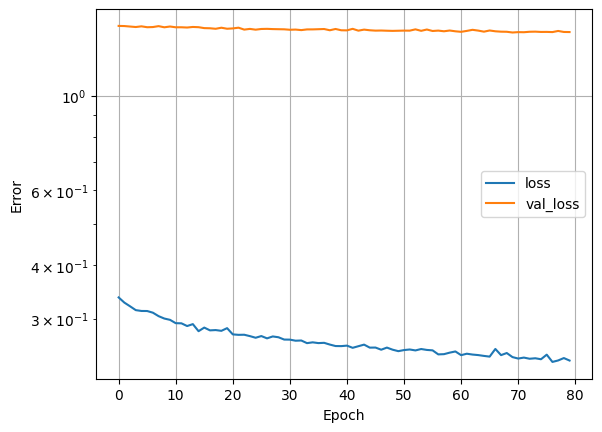

In [14]:
we.plot_loss(history)

In [15]:
predictions = model.predict(X_test_scaled)

105/105 [==============================] - 4s 11ms/step


In [16]:
X_test_scaled.shape

(3344, 24, 11)

In [17]:
Y_test_scaled.shape

(3344, 24)

In [18]:
predictions.shape

(3344, 24)

In [ ]:
Y

In [21]:
predictions_original_scale = we.inverse_min_max_normalize(predictions, Y_test_scaled)

In [22]:
predictions_original_scale = predictions_original_scale.reshape(predictions_original_scale.shape[0], -1)

In [23]:
predictions = predictions.reshape(predictions.shape[0], -1)

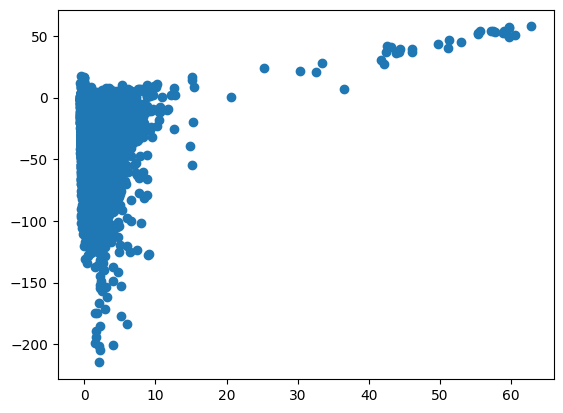

In [32]:
plt.scatter(Y_test_scaled, Y_test_scaled - predictions_original_scale)

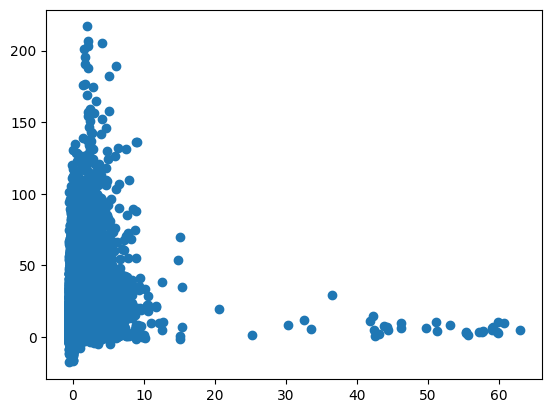

In [33]:
plt.scatter(Y_test_scaled, predictions_original_scale)

In [25]:
predictions.shape

(3344, 24)

In [26]:
len(predictions)

3344

In [27]:
Y_test_scaled.shape

(3344, 24)